# Sina's Wieners
### A Discrete Time Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modsim import *
import pandas as pd
from datetime import date, timedelta
from scipy import stats
import seaborn as sns

sns.set()
plt.style.use('dark_background')

### Generate 10k Customers

Attributes:

* Salary
* Cash
* Credit
* Affinity
* Willingness

The amount of money each is given will be based on an estimated average/mean salary for 2020.  We do not have complete information from later years.  The mean was \$53,383, and the median \$34,612.  Theoretically, half of the people should have a salary below the median, and the median and mean should line up.  In reality, this figure is highly skewed:

!["Source: https://www.ssa.gov/OACT/COLA/central.html"](wages.png)

Over time, the pay of management has risen far faster than the pay of "regular" employees.  So, for this experiment, we will assume that the hyper rich don't care for hotdogs, and that the median salary is the most realistic for the most people.  Median household salary for 2020 was around \$67,000 according to the US Census, and the poverty line for a 3-person household was \$21,700 according to the department of Health and Human Services.

For simplicity, we will assume salaries for individual customers of Sina's Wieners to be normally distributed, centered around \$35,000, with a standard deviation of \$14,000.  We know that reality is much messier than this, but we have to start somewhere.



Cash and credit will initialize at zero.

The affinity score will range from 0 to 1, again normally distributed around the center of the range.

Finally, we have willingness to download and use the app.  This value is either a 0 or 1.  From 1 January, 10% of the population will be ready to try it.  Whenever somebody makes a purchase with credit rewards, they will tell 3 friends about it, and each will have a 50% chance of downloading the app. 1 will be a regular customer, and 2 will be outside customers.

In [2]:
def generate_customer():
    """
    Generate a customer with some randomly given attributes.
    Returns: Tuple with customer attributes.
    """

    # Salary normally distributed around 35k
    salary = np.random.normal(loc=35000, scale=14000)

    # Affinity for the wieners normally distributed around 1/2
    affinity = np.random.normal(loc = 0.5, scale = 0.1)

    cash = 0
    credit = 0
    willingness = 0

    return (salary, cash, credit, affinity, willingness)


def create_population(n):
    """
    Create the population of customers.
    Returns: Dataframe with population.
    """
    # General shape of a person
    population = pd.DataFrame(columns=['salary', 'cash', 'credit',
                                       'affinity', 'willingness'])


    for i in range(n):
        population.loc[i] = generate_customer()

    # Randomly select alpha testers
    users = population.sample(frac = 0.1)
    users.willingness = 1
    population.update(users)

    # Biweekly pocket money
    population.cash = (population.salary / 26) * 0.05

    population['salary'] = population['salary'].astype(int)
    population['cash'] = population.cash.astype(int)

    return population

Now, we must give these people some cash to eat hotdogs with for the first 2-week period.  They will get paid on the 1st and 15th of each month, which means this number will be replenished.  The cash will not carry over, but the credit will.

Their hotdog money is equal to 5% of the pay received in a pay period.

We must also select the people who feel like trying out the app.

In [3]:
test_population = create_population(1000)
test_population

,salary,cash,credit,affinity,willingness
0,18748,36,0.0,0.440288,0.0
1,50810,97,0.0,0.533981,0.0
2,31883,61,0.0,0.303305,0.0
3,38057,73,0.0,0.617924,0.0
4,31925,61,0.0,0.586459,0.0
...,...,...,...,...,...
995,19161,36,0.0,0.454099,0.0
996,24665,47,0.0,0.400149,0.0
997,45414,87,0.0,0.506873,0.0
998,55938,107,0.0,0.398908,0.0


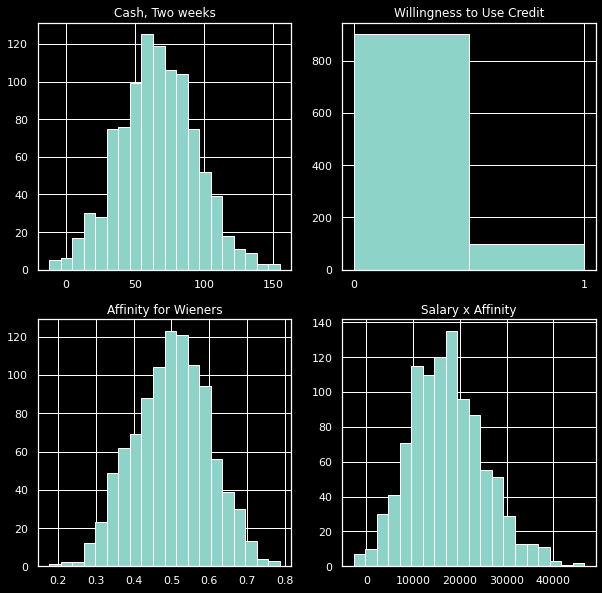

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax[0,0].hist(test_population.cash, bins=20)
ax[0,0].set_title('Cash, Two weeks')

ax[0,1].hist(test_population.willingness, bins=2)
ax[0,1].set_title('Willingness to Use Credit')
ax[0,1].xaxis.set_ticks([0,1])

ax[1,0].hist(test_population.affinity, bins=20)
ax[1,0].set_title('Affinity for Wieners')

ax[1,1].hist(test_population.affinity * test_population.salary, bins = 20)
ax[1,1].set_title('Salary x Affinity')

plt.show()

### Federal Holidays

No business will be conducted on these days

In [5]:
holidays = (date(2020, 1, 1), date(2020, 1, 20),
            date(2020, 2, 17),
            date(2020, 5, 25),
            date(2020, 7, 4),
            date(2020, 9, 7),
            date(2020, 11, 11), date(2020, 11, 26),
            date(2020, 12, 24), date(2020, 12, 25))

### Average Daily Customers

In 2019, Burger King had around 18,000 restaurant locations around the world, serving 11 million customers per day.  We will use this information for our average daily customer rate of = 612, assuming arbitrarily that this applies to a group of 10,000 people who could potentially wander in.

source: https://expandedramblings.com/index.php/burger-king-statistics-facts/

The hottest day of the year in 2020 was July 21.  This was 202 days away from the beginning of the year.  We will use this information to model the customers coming in each day.  The coldest day was January 17th... and without putting in this information, we hit very close with a normal cosine oscillation.

<AxesSubplot:>

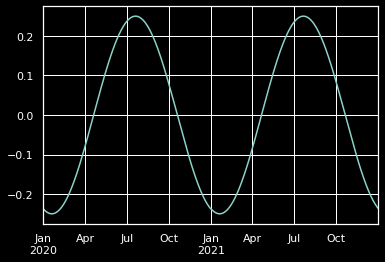

In [6]:
df = pd.DataFrame(index=pd.date_range(start='2020-01-01', end='2021-12-31', freq='D'))
amplitude = 0.25
df['y'] = np.cos((df.index.to_series().dt.day_of_year - 202)/365*2*np.pi) * amplitude
df['y'].plot()

### Define Initial Parameters

* Date begins at Jan 1
* Start in Winter
* Generate a population in the System object
* Include holidays
* Good experience rate 99.5%
* Customer reward rate variable
* Customers can buy in discrete denominations of $8 - $20, counting by $4

In [7]:
params = Params(
    holidays = holidays,
    exp_rate = 0.995,
    menu = (8, 12, 16, 20),
    t_0 = date(2020, 1, 1),
    t_end = date(2021, 12, 31),
    customers = create_population(3000),
    )

def make_system(params, reward):
    """
    Make a system with the given parameters.
    Returns: System object.
    """
    init = State(
        customers = params.customers,
        day = params.t_0,
        buyers = None,
        capacity = 0.06125,
        reward = reward,
        history = [])
    
    return System(params, state = init)

system = make_system(params, reward = 0.1)

In [8]:
def turnout(system):
    """
    Calculate the customer turnout for a given day.
    Returns: int.
    """
    t_0 = params.t_0.strftime('%Y-%m-%d')
    t_end = params.t_end.strftime('%Y-%m-%d')

    day = system.state.day.strftime('%Y-%m-%d')
    df = pd.DataFrame(index=pd.date_range(start=t_0, end=t_end, freq='D'))
    factor = 0.25

    
    df['y'] = np.cos((df.index.to_series().dt.day_of_year - 202)/365*2*np.pi) * factor
    p = df['y'].loc[day] + 1

    return int(p * len(system.state.buyers) * system.state.capacity)

### Start Day

* If the day is 1 or 15, wipe the cash, and refill the amount.
* Choose customers based on:
    * cash and credit available
    * affinity
    * restaurant average daily numbers

In [9]:
def start_day(system):
    """
    Start a day in the system.
    Returns: System object.
    """
    
    # Potential customers are those who have cash or credit,
    # and who don't hate the restaurant.
    cash_potential = system.state.customers[system.state.customers['cash'] >= 8]
    credit_potential = system.state.customers[system.state.customers['credit'] >= 8]

    total_potential = cash_potential.merge(credit_potential, how='outer')
    system.state.buyers = total_potential[total_potential['affinity'] > 0.05]

    # Customers are selected at random, n = seasonal daily average
    system.state.buyers = system.state.buyers.sample(turnout(system))

    return system

### User Aqcuisition

Whenever a person makes a successful purchase with credit:

* They (casually) tell three friends about the service
    * 1 is already a customer
    * 2 are potential new customers
* Each has a 1/3 chance of downloading and using the rewards service
    * People who are not already customers will start enjoying the restaurant when they begin using the rewards program

In [10]:
def word_of_mouth(system):
    """
    On credit purchases, customers will spread the good word.
    Returns: System object.
    """
    # An old customer may decide to accept credit
    if flip(0.33):
        oldie = system.state.customers[system.state.customers['willingness'] == 0].sample(1)
        oldie['willingness'] = 1
        system.state.customers.update(oldie)

    # A new customer may decide to accept credit
    if flip(0.33):
        i = len(system.state.customers) + 1
        system.state.customers.loc[i] = generate_customer()
        system.state.customers.loc[i]['willingness'] = 1

    # A new customer may decide to accept credit
    if flip(0.33):
        i = len(system.state.customers) + 1
        system.state.customers.loc[i] = generate_customer()
        system.state.customers.loc[i]['willingness'] = 1
    
    return system

### Conducting Business

* Selected customers make purchases
    * purchases are either cash or credit, not both
    * purchases are always in discrete amounts
* Rewards issued to "willing" customers
* Experience is good/bad
* History saved
    * number of customers
    * total purchases cash
    * total purchases credit
    * total credit issued

In [11]:
def purchase_item(system, today, i):
    """Purchase an item with credit, and tell two people."""
    # Choose an item from the menu.
    item = np.random.choice(params.menu)
    
    # If it is too expensive, the person buys the cheapest item.
    if (item > system.state.buyers.loc[i,'cash']) & (item > system.state.buyers.loc[i,'credit']):
        item = 8

    # Buy with credit
    if item <= system.state.buyers.loc[i, 'credit']:
        system.state.buyers.loc[i,'credit'] -= item
        today[2] += item
    
        # This cutomer spreads the good word
        system = word_of_mouth(system)
        return system, today

    # Buying with cash
    elif item <= system.state.buyers.loc[i,'cash']:
        system.state.buyers.loc[i,'cash'] -= item
        today[3] += item

        # Issue credit
        if system.state.buyers.loc[i,'willingness'] == 1:
            system.state.buyers.loc[i,'credit'] += item * system.state.reward
            today[4] += system.state.buyers.loc[i,'credit']

        return system, today

In [12]:
def conduct_business(system):
    """
    Makes sales for a day and issue credit accordingly.
    Returns: System object.
    """

    # For the history matrix... day, number of customers,
    # credit purchases, cash purchases, credit issued.
    today = [system.state.day,
             len(system.state.buyers),
             0, 0, 0]

    if len(system.state.buyers) != 0:
        for i in system.state.buyers.index:
            purchase_item(system, today, i)
            
            # Punish negative dining experience, slightly reward a positive one
            if flip(params.exp_rate):
                system.state.buyers.loc[i,'affinity'] *= 1.25
            else:
                system.state.buyers.loc[i,'affinity'] *= 0.75

            # Update customer information
            system.state.customers.update(system.state.buyers)

    # Update history
    if system.state.history:
        system.state.history.append(today)
    else:
        system.state.history = [today]

    return system

### After Hours Trading

* Trade or keep assets from the day, based on affinity score
* Trades subtract credit from seller
* Trades add 80% cash to seller
* Trades add credit to buyer
* Trades subtract 80% cash from buyer


In [13]:
def trade_rewards(system):
    """
    Dissatisfied customers trade credit for 80% cash.
    Returns: System object.
    """
    
    users = system.state.customers[system.state.customers['willingness'] != 0]
    dissatisfied = users[users.affinity < 0.05]
    satisfied = users[users.affinity >= 0.05]

    # Loop through dissatisfied customers
    for i in dissatisfied.index:
        seller = dissatisfied.loc[i]
        if satisfied.cash.sum() < seller.credit:
            break
        
        # Trade until credit is gone
        while person.credit > 0:
            # Find a random buyer and trade
            buyer = satisfied.sample(1)
            credit_swap = min(seller.credit, buyer.cash * 0.8)
            seller.credit -= credit_swap
            buyer.credit += credit_swap
            buyer.cash -= credit_swap * 0.8
            seller.cash += credit_swap * 0.8

    system.state.customers.update(users)
    return(system)

### End Day

* Pay people on pay days
* increase the date by one day

In [14]:
def end_day(system):
    """
    End a day in the system.
    Return: system object.
    """
    # Pay day!
    if system.state.day == (1 | 15):
        system.state.customers.cash = 0.05 * system.state.customers.salary / 26
    
    # Update day
    system.state.day += timedelta(days=1)
    
    return system

### Run Simulation

* start_day()
* if day is holiday skip to end_day()
* conduct_business()
* after_hours()
* end_day()
* return system object

In [15]:
def run_simulation(system):
    """
    Run the simulation.
    Returns: System object.
    """

    while system.state.day <= date(2021, 12, 31):
        system = start_day(system)

        # Nobody works on federal holidays!
        if system.state.day in params.holidays:
            system = end_day(system)

        # This is a normal day
        else:
            system = conduct_business(system)
            system = trade_rewards(system)
            system = end_day(system)
            
    return system

In [16]:
system = make_system(params, reward = 0.1)
final = run_simulation(system)

history = pd.DataFrame(final.state.history,
    columns=['day', 'customers', 'credit_purchases', 'cash_purchases', 'credit_issued'])

### Descriptive Graphs

Text(0.5, 1.0, 'Credit Issued')

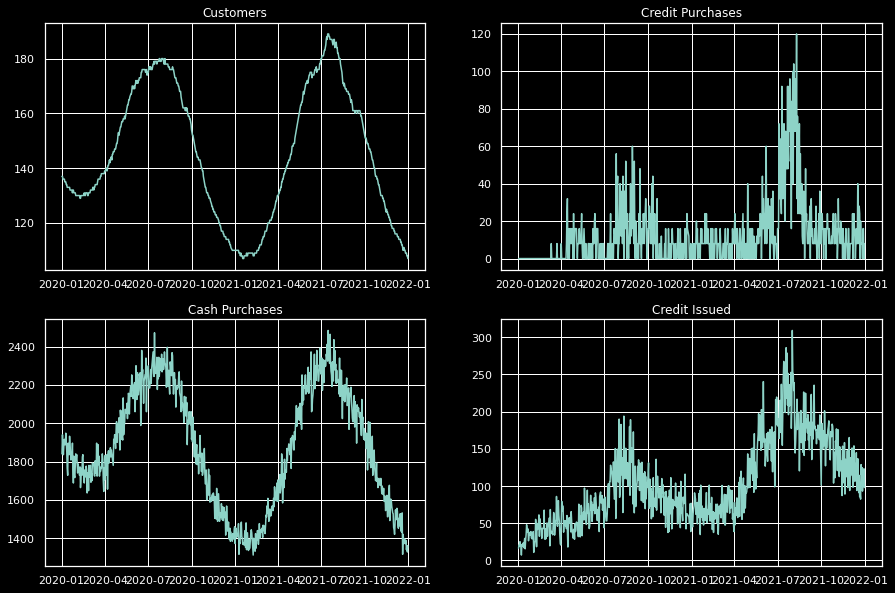

In [17]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(15,10))

ax[0,0].plot(history.day, history.customers)
ax[0,0].set_title('Customers')

ax[0,1].plot(history.day, history.credit_purchases)
ax[0,1].set_title('Credit Purchases')

ax[1,0].plot(history.day, history.cash_purchases)
ax[1,0].set_title('Cash Purchases')

ax[1,1].plot(history.day, history.credit_issued)
ax[1,1].set_title('Credit Issued')

In [18]:
final.state.customers, sum(final.state.customers.willingness)

(            salary  cash  credit  affinity  willingness
 0     81226.000000   0.0     7.6  9.482888          1.0
 1     67397.000000   1.0     4.8  7.157793          1.0
 2     81226.000000   8.0     6.8  7.586310          1.0
 3     81226.000000   4.0     7.2  7.586310          1.0
 4     67397.000000   1.0     4.8  5.726234          1.0
 ...            ...   ...     ...       ...          ...
 3712  24282.802476   0.0     0.0  0.538120          1.0
 3713   9581.052674   0.0     0.0  0.395126          1.0
 3714  29112.504232   0.0     0.0  0.478891          1.0
 3715  14441.964697   0.0     0.0  0.559145          1.0
 3716  13902.624493   0.0     0.0  0.346272          1.0
 
 [3716 rows x 5 columns],
 1513.0)

### Cost/Benefit Analysis

What is the optimal reward rate with these parameters?

In [ ]:
def net_profit(history):
    """
    Returns: net profit.
    Each purchase costs the business $0.40 to produce for each $1 purchased
    """
    revenue = history.cash_purchases.sum()
    net = revenue - (history.credit_purchases.sum() + history.credit_purchases.sum()) * 0.6
    return net

In [20]:
reward_array = linspace(0, 0.09, 10)

In [21]:
def sweep_rewards(reward_array, params):
    """
    Sweeps a range of values for customer rewards.
    Returns: Sweep object
    """
    sweep = SweepSeries()
    for rate in reward_array:
        system = make_system(params, rate)
        final = run_simulation(system)

        history = pd.DataFrame(final.state.history,
            columns=['day', 'customers', 'credit_purchases',
                     'cash_purchases', 'credit_issued'])
    
        sweep[rate] = net_profit(history)

    return sweep


In [22]:
reward_sweep = sweep_rewards(reward_array, params)

In [23]:
reward_sweep

,values
0.00,1313452.0
0.01,1314508.0
0.02,1317008.0
0.03,1314664.0
0.04,1313352.0
0.05,1313548.0
0.06,1313353.6
0.07,1308916.0
0.08,1287972.0
0.09,1258358.4


Text(0.5, 1.0, 'Net Profit vs. Reward, 3k customers, 2 Years')

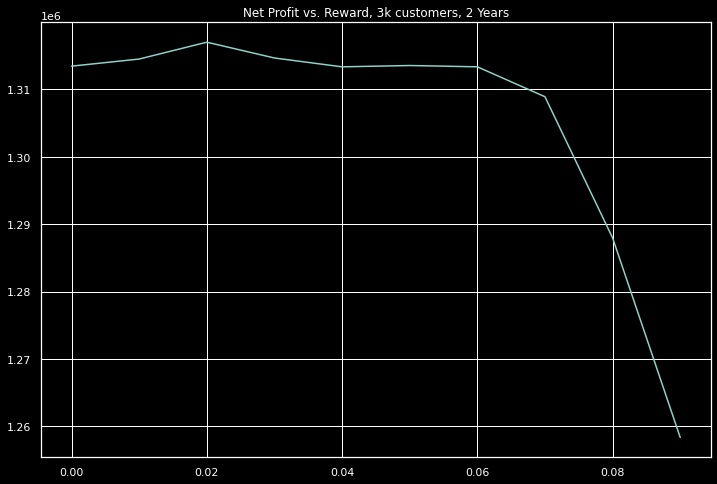

In [30]:
plt.figure(figsize=(12,8))
plt.plot(reward_sweep.index, reward_sweep.values)
plt.title('Net Profit vs. Reward, 3k customers, 2 Years')